In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt

import sys
sys.path.append('/localhome/prathmeshmadhu/my_github/custom_libs/lshash')
from lshash import LSHash
from PIL import Image
from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)

In [73]:
path = Path('/localhome/prathmeshmadhu/work/EFI/Data/Classical_Arch/latest')

In [74]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64))

In [75]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

Number of classes 21
['Altar', 'Apollon', 'Arrow', 'Bed', 'Bow', 'Column-Cockerell_bf', 'Column-Cockerell_rf', 'Dolphin', 'Door', 'Fish', 'Harpe', 'Hippocamp', 'Hoop', 'Kerykeion', 'Pomegranate', 'Poseidon', 'Trident', 'VGG_ClassArch_Pursuits', 'VGG_classArch-Poseidon-Pursuit', 'images', 'not labelled']


In [76]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))
print('Test dataset size: {0}'.format(len(data.valid_ds.x)))

Train dataset size: 7572
Test dataset size: 1893


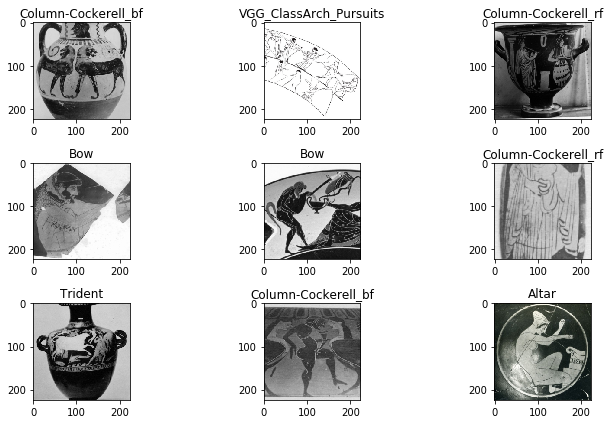

In [77]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [82]:
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


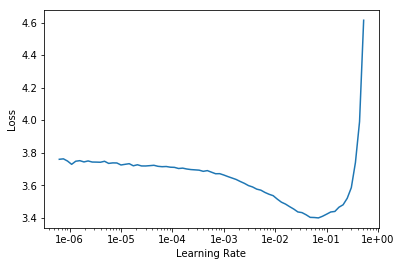

In [83]:
## Finding Ideal learning late
learn.lr_find()
learn.recorder.plot()

In [84]:
## Fitting 5 epochs
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.707216,2.382596,0.257792,01:36
1,2.370399,2.218237,0.299525,01:36
2,2.156136,2.157820,0.329107,01:36
3,1.969975,1.984548,0.353936,01:38
4,1.779579,1.939360,0.360803,01:35


In [ ]:
learn.unfreeze()
## Fitting 5 epochs
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# learn.fit_one_cycle(15,1e-2)

In [37]:
## Saving model weights
learn.save('class_arch_image_sim_stg2-rn34')

In [38]:
learn = cnn_learner(data, models.resnet34).load('class_arch_image_sim_stg2-rn34')

In [59]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

In [60]:
## By running this feature vectors would be saved in sf variable initated above
# _= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [61]:
# img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
img_path = [str(x) for x in list(data.valid_ds.items)]
feature_dict = dict(zip(img_path,sf.features))

In [62]:
## Exporting as pickle
pickle.dump(feature_dict, open(path/"class_arch_valid_feature_dict.p", "wb"))

## Using Locality Sensitive hashing to find near similar images

In [63]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'class_arch_valid_feature_dict.p','rb'))

In [64]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [65]:
## Exporting as pickle
pickle.dump(lsh, open(path/'class_arch_valid_lsh.p', "wb"))

In [66]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'class_arch_valid_feature_dict.p','rb'))
lsh = pickle.load(open(path/'class_arch_valid_lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

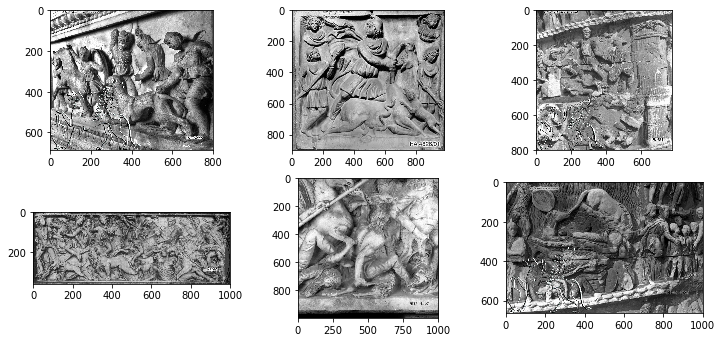

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/VGG-CA-Trousers/7932 Sarkophagkasten des sog. Alexandersarkophages, Pantherjagd3.jpg


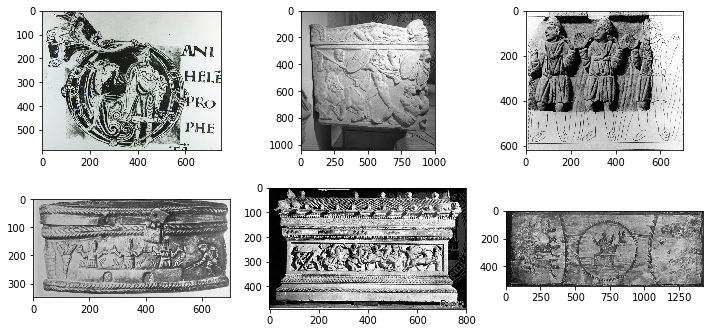

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/Daniel/DC7E64E8-122C-42A2-8FB9-9362FBD00F89.jpg


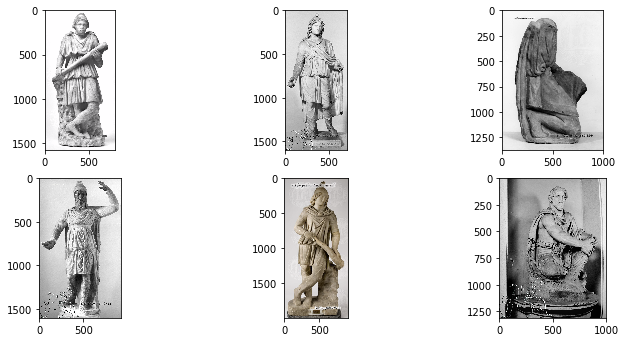

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/VGG-CA-Mithras/1081008.jpg


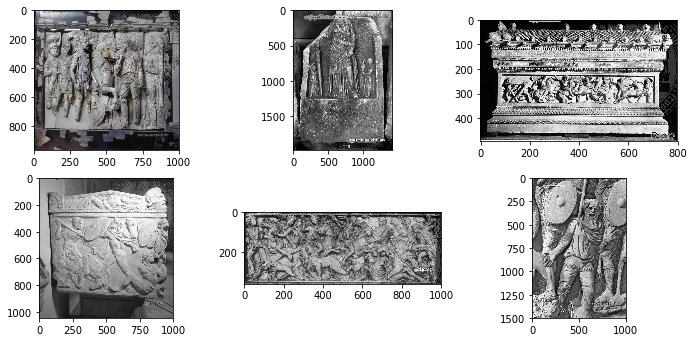

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/VGG-CA-Trousers/52311 Trajanischer Elfenbeinfries aus Ephesos.jpg


In [72]:
for i in range(11,15):
    get_similar_item(i, feature_dict, lsh,5)
    print (list(feature_dict.keys())[i])

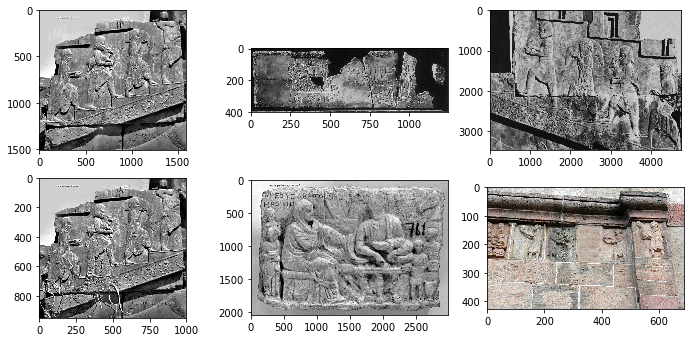

In [48]:
get_similar_item(100, feature_dict, lsh,5)

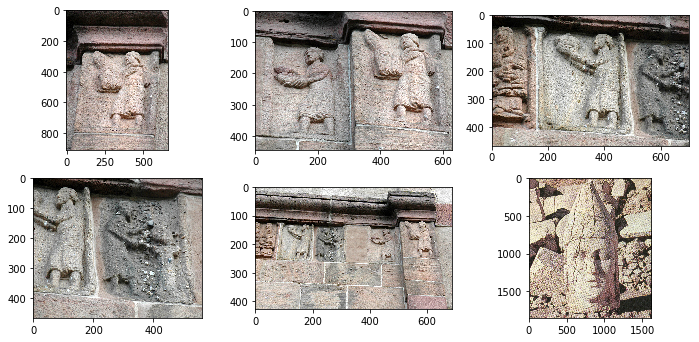

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/Servants/A353CE9C-B740-4E9D-A11D-7B1C81F05727.jpg


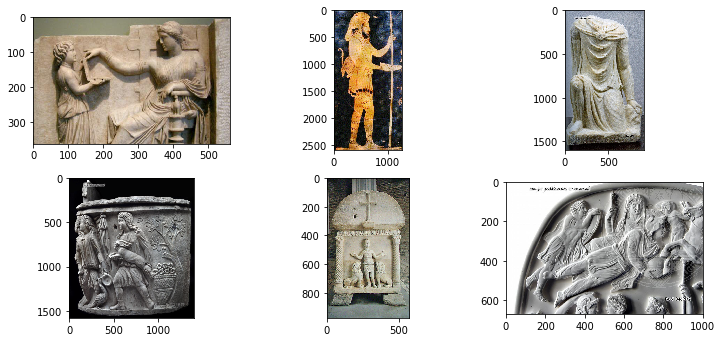

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/Servants/WUKA1454692441 2.jpg


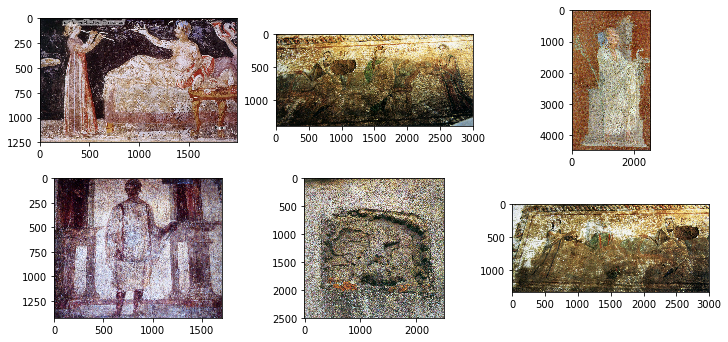

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/Servants/1253470-2.jpg


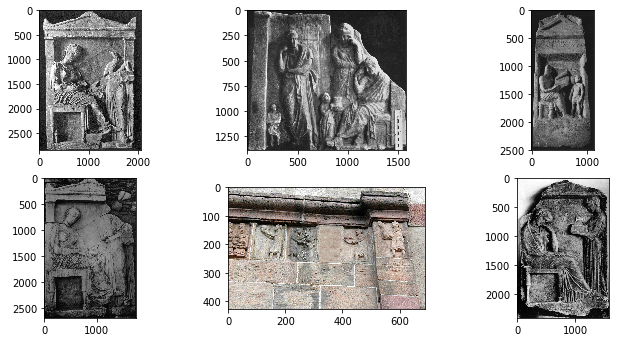

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/Servants/MZKA1386837232.jpg


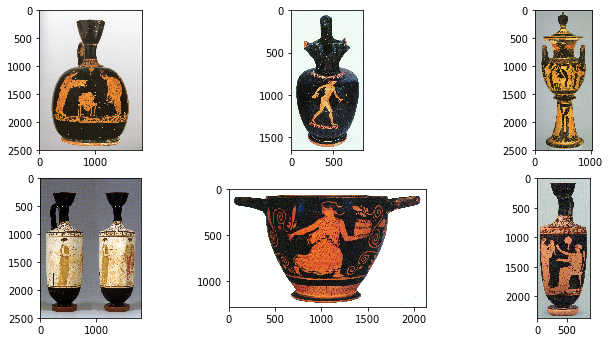

/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/latest/Servants/SAKA1279620504.jpg


In [52]:
for i in range(5):
    get_similar_item(i, feature_dict, lsh,5)
    print (list(feature_dict.keys())[i])